In [147]:
! pip install statsmodels

     |████████████████████████████████| 8.6MB 492kB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/ea/0c/5f61f1a3d4385d6bf83b83ea495068857ff8dfb89e74824c6e9eb63286d8/patsy-0.5.1-py2.py3-none-any.whl
You should consider upgrading via the 'pip install --upgrade pip' command.


In [300]:
import os
import os.path as op
import sys

In [301]:
import matplotlib.pyplot as plt

In [302]:
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs, read_ica

In [303]:
from scipy.stats import skew

In [304]:
from pylab import rcParams

In [305]:
from mne.preprocessing import ICA

In [306]:
import numpy as np

In [653]:
subject = 10
task = 1

path = "./full-data/eegmmidb-1.0.0.physionet.org/S{0:03d}/S{0:03d}R{1:02d}.edf".format(subject, task)

In [655]:
eeg = mne.io.read_raw_edf(
    path,
    preload=True,
    exclude=["T9..", "T10."]
)

Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S010/S010R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...


In [656]:
eeg.rename_channels(lambda x: x.strip('.'))

In [657]:
start = 20
stop = 40

In [658]:
eeg.filter(2, 50)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)



<RawEDF  |  S010R01.edf, n_channels x n_times : 62 x 9760 (61.0 sec), ~4.7 MB, data loaded>

In [659]:
ica = ICA()
ica.fit(eeg)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 3.0s.


<ICA  |  raw data decomposition, fit (fastica): 9760 samples, 62 components, channels used: "eeg">

In [660]:
ica_eeg = ica.get_sources(eeg)

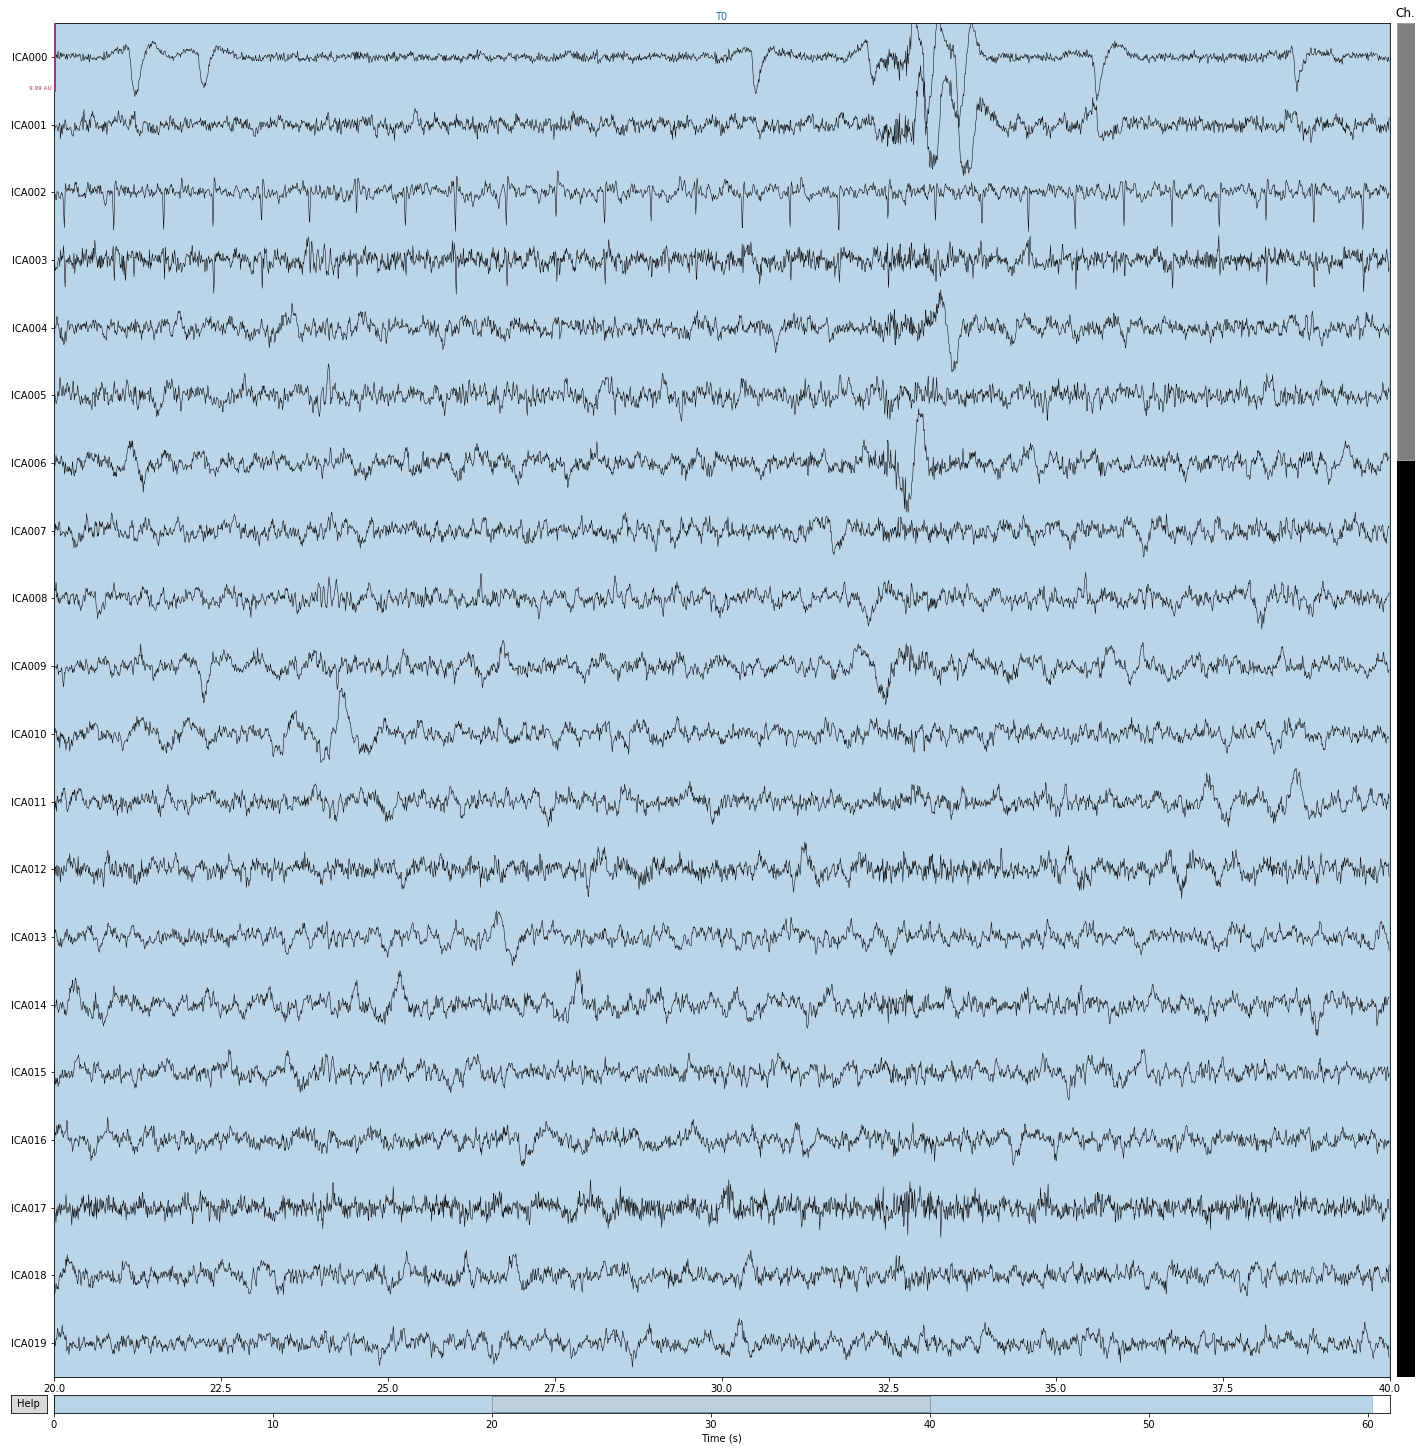

In [661]:
rcParams['figure.figsize'] = 20, 20
mne.viz.plot_raw(
    ica_eeg, 
    start=start, 
    duration=stop - start, 
    show=False, 
    scalings=np.percentile(np.abs(ica_eeg[0:10000][0]), 99.9)
)
plt.show()

# TODO eog and ecg like channels

In [662]:
eog_pick = mne.pick_channels(eeg.info["ch_names"], ["Fp1", "Fp2", "F3", "F4", "O1", "O2"])

In [663]:
eog_pick

array([21, 23, 31, 35, 58, 60])

In [664]:
eeg_data, eeg_time = eeg[:]

In [665]:
ica_data, ica_time = ica_eeg[:]

In [666]:
max_values = np.max(np.abs(ica_data), axis=1)
vars_values = np.var(ica_data, axis=1)
f1_values = max_values / vars_values

In [667]:
f2_values = np.abs(skew(ica_data, axis=1))

In [668]:
f3_values = np.array([np.mean([np.abs(np.corrcoef(d, eeg_data[p])) for p in eog_pick]) for d in ica_data])

In [669]:
# def kl_divergence(p, q):
    
#     return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# f4_values = np.array([[kl_divergence(d, eeg_data[p]) for p in eog_pick] for d in ica_data])

In [670]:
# dataset = []

In [671]:
eog_channels = [0, 1]
ecg_channels = [2]

In [672]:
for i, _ in enumerate(ica_data):
    data_part = [f1_values[i], f2_values[i], f3_values[i]]
    if i in eog_channels:
        data_part.append("EOG")
    elif i in ecg_channels:
        data_part.append("ECG")
    else:
        data_part.append("EEG")
    dataset.append(data_part)

In [673]:
# for p in ica_data[np.argsort(-np.array(f_values))[0:5]]:
#     plt.figure(figsize=(10, 5))
#     plt.plot(p[1000:2000])
#     plt.show()

In [674]:
import json 

In [675]:
json.dump(dataset, open("ica_features.json", "w"))

# Labeling
- Save f values (f1, f2, f3)
- Save label (ECG, EOG, None)
- Repeat for multiple files

# Filtering

In [89]:
filtered_eeg = ica.apply(eeg.copy(), exclude=[0, 1])

Transforming to ICA space (62 components)
Zeroing out 2 ICA components


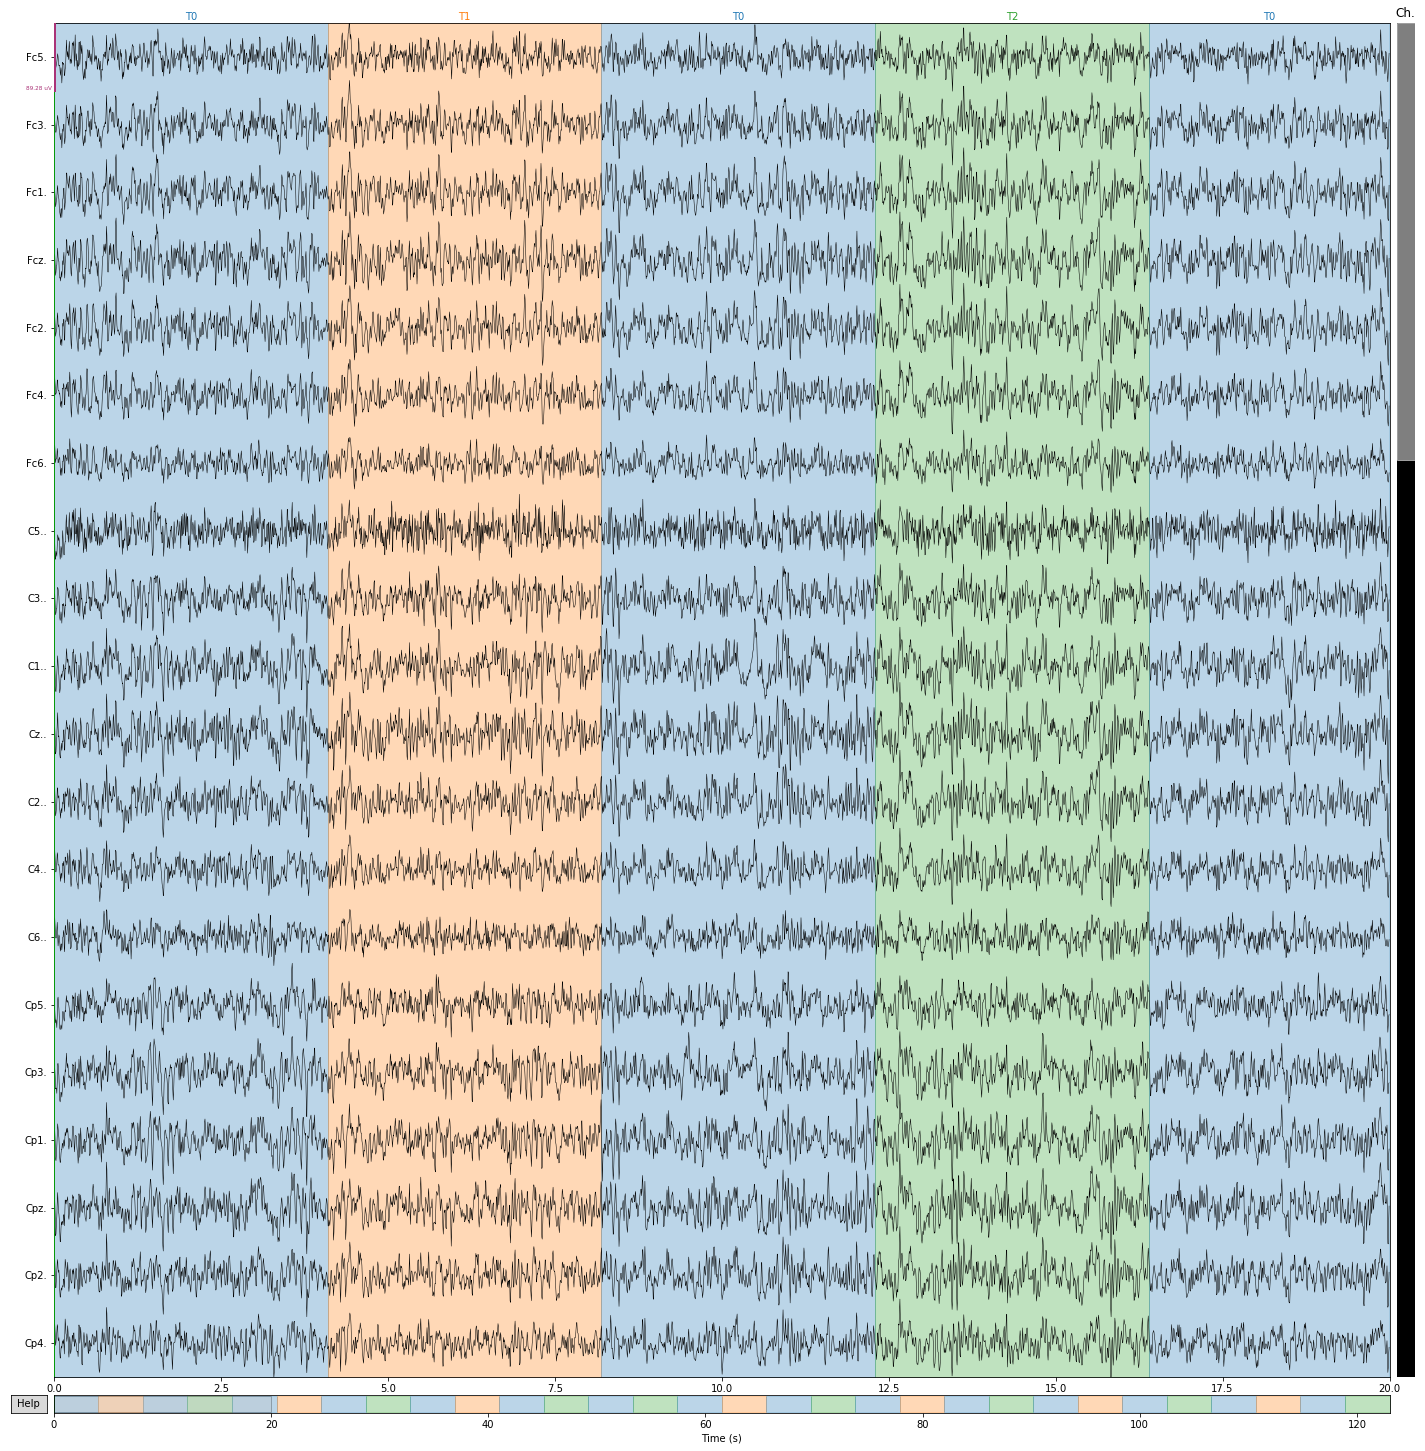

In [90]:
mne.viz.plot_raw(
    filtered_eeg, 
    start=start, 
    duration=stop - start, 
    show=False, 
    scalings=np.percentile(np.abs(filtered_eeg[0:10000][0]), 99)
)
plt.show()

In [72]:
filtered_eeg.save("test_events.edf", overwrite=True)
# filtered_eeg.save("test_baseline.edf", overwrite=True)

Overwriting existing file.
Writing /home/noomkcalb/Документы/neuroscience/right-left/test_events.edf
Closing /home/noomkcalb/Документы/neuroscience/right-left/test_events.edf [done]


<ipython-input-72-0c5a2badb4e1>:1: RuntimeWarning: This filename (/home/noomkcalb/Документы/neuroscience/right-left/test_events.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("test_events.edf", overwrite=True)


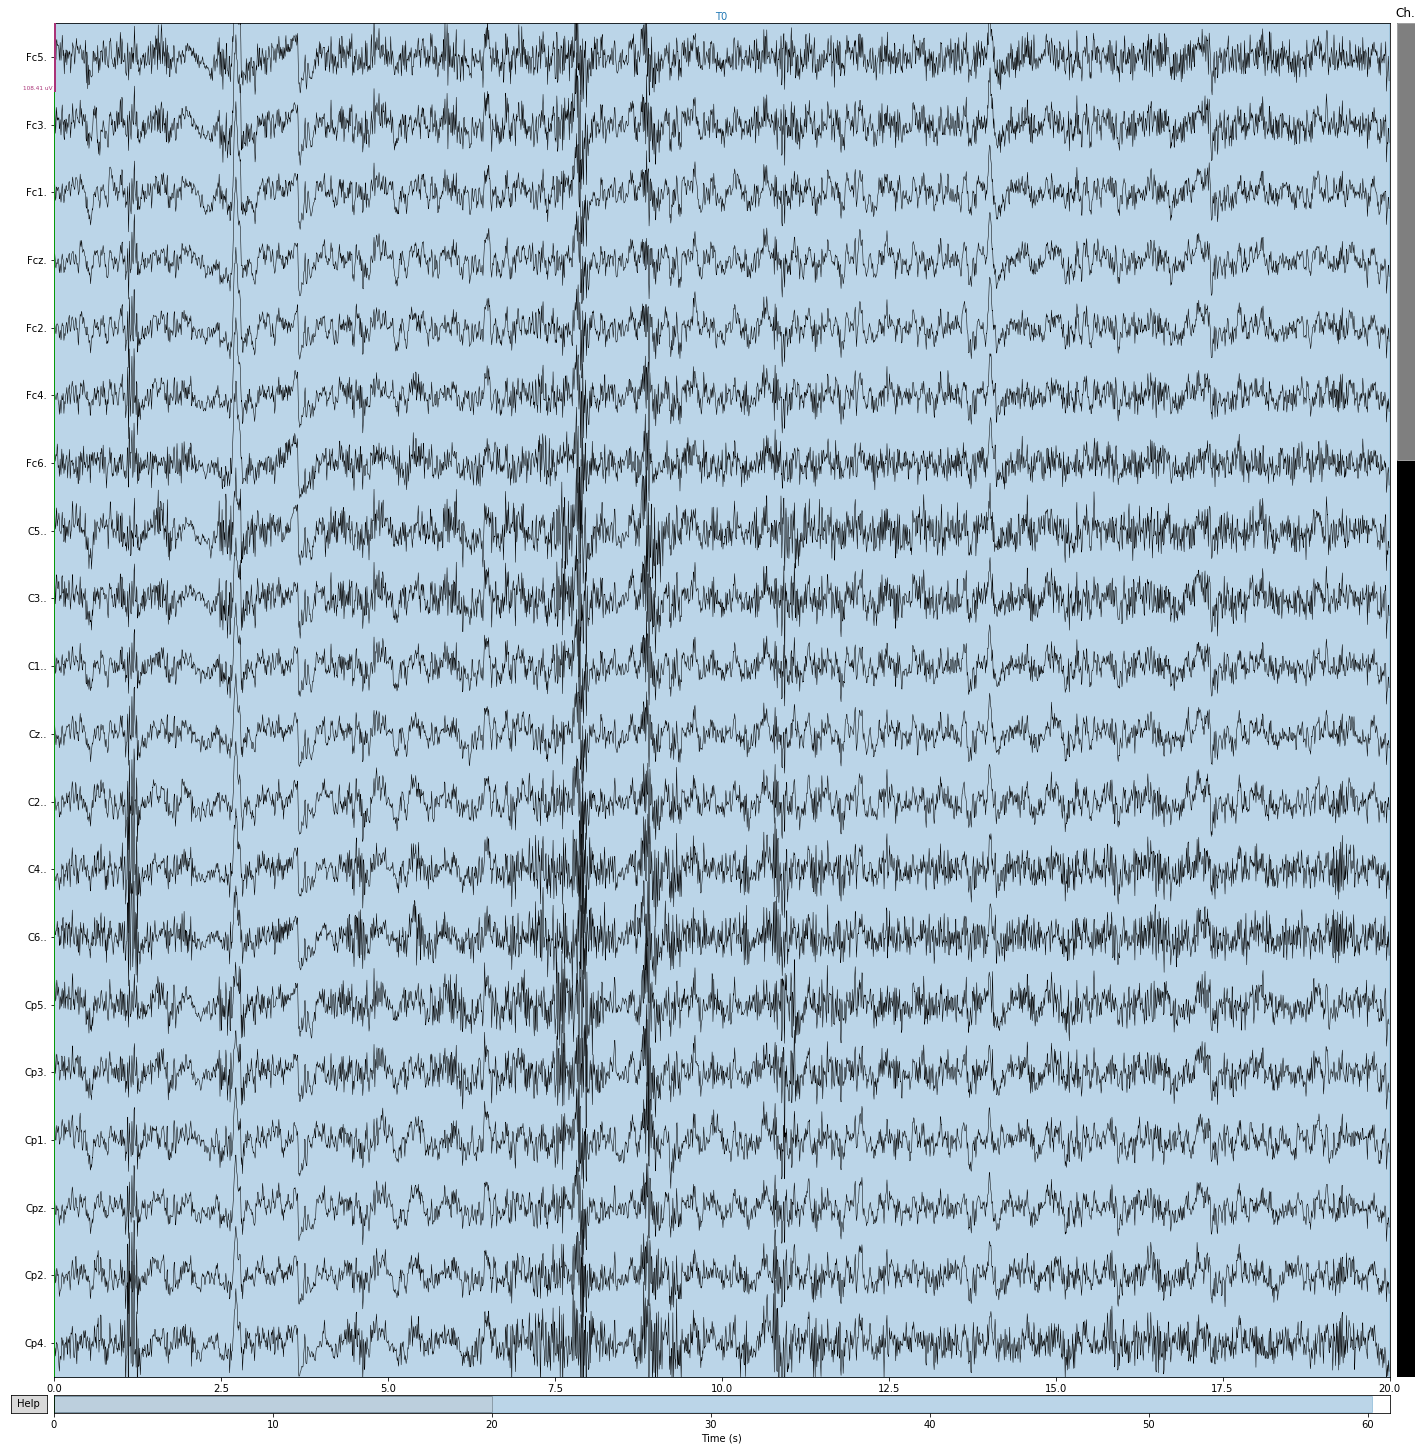

In [35]:
rcParams['figure.figsize'] = 20, 20
mne.viz.plot_raw(
    eeg, 
    start=start, 
    duration=stop - start, 
    show=False, 
    scalings=np.percentile(np.abs(eeg[0:10000][0]), 99)
)
plt.show()

# ICA Classification

In [676]:
import pandas as pd

In [677]:
import seaborn as sns

In [678]:
ica_features = json.load(open("./ica_features.json"))

In [679]:
ica_features_df = pd.DataFrame(ica_features, columns=["f1", "f2", "f3", "type"])

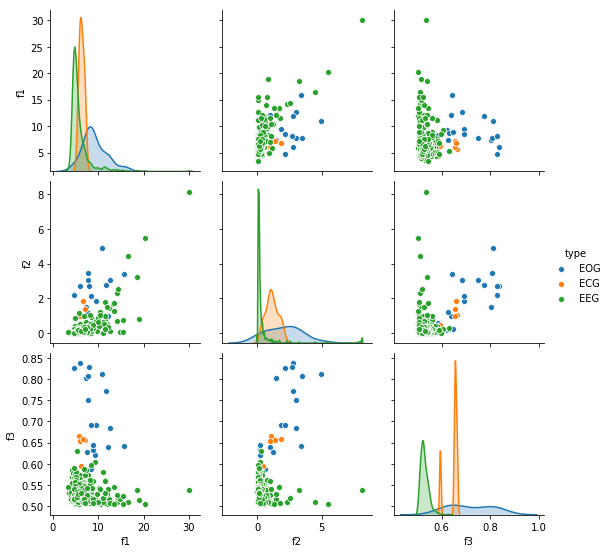

In [680]:
sns.pairplot(ica_features_df, vars=["f1", "f2", "f3"], hue="type")

In [819]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [820]:
X = ica_features_df[["f1", "f2", "f3"]]
y = ica_features_df["type"] != "EEG"

In [821]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [822]:
y.value_counts()

False    597
True      23
Name: type, dtype: int64

In [823]:
grid = {
    "C": np.linspace(0.1, 10, 100)
}
model = LogisticRegression()
search = GridSearchCV(model, grid, scoring="f1", cv=3)
search.fit(X, y)

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([ 0.1,  0.2,  0.3,  0.4,  0....
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5

In [824]:
search.best_estimator_

LogisticRegression(C=1.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [825]:
from sklearn.metrics import recall_score

In [826]:
recall_score(y, search.predict(X))

0.9130434782608695

In [827]:
search.best_score_

0.9130844645550528

In [828]:
from joblib import dump, load

In [829]:
dump(search.best_estimator_, "artifacts_model.pkl")

['artifacts_model.pkl']

In [830]:
dump(scaler, "artifacts_scaler.pkl")

['artifacts_scaler.pkl']

# Model usage

In [832]:
model = load("artifacts_model.pkl")
scaler = load("artifacts_scaler.pkl")

In [833]:
def read_eeg(path):
    eeg = mne.io.read_raw_edf(
        path,
        preload=True,
        exclude=["T9..", "T10."]
    )

    eeg.rename_channels(lambda x: x.strip('.'))

    eeg.filter(2, 50)
    
    return eeg, eeg[:][0]

In [834]:
def train_ica(eeg):
    ica = ICA()
    ica.fit(eeg)
    ica_eeg = ica.get_sources(eeg)
    return ica, ica_eeg[:][0]

In [835]:
def extract_artifact_features(ica_data, eeg_data):
    global scaler
    
    f1_values = np.max(np.abs(ica_data), axis=1) / np.var(ica_data, axis=1)
    
    f2_values = np.abs(skew(ica_data, axis=1))
    
    f3_values = np.array([np.mean([np.abs(np.corrcoef(d, eeg_data[p])) for p in eog_pick]) for d in ica_data])
    
    return scaler.transform(np.vstack([f1_values, f2_values, f3_values]).T)

In [836]:
def filter_artifacts(ica_features, ica, eeg):
    global model
    classes = model.predict(ica_features)
    print(classes)
    indices = np.nonzero(classes)[0]
    print(indices)
    filtered_eeg = ica.apply(eeg.copy(), exclude=indices)
    return filtered_eeg

In [847]:
def filter_main(path):
    global scaler, model
    eeg_to_work, eeg_data = read_eeg(path)
    ica_to_work, ica_eeg_data = train_ica(eeg_to_work)
    ica_features = extract_artifact_features(ica_eeg_data, eeg_data)
    filtered_eeg = filter_artifacts(ica_features, ica_to_work, eeg_to_work)
    return filtered_eeg

In [849]:
from tqdm import tqdm_notebook

In [851]:
for subject in tqdm_notebook(range(1, 110)):
    for task in [4, 8, 12]:
        path = "./full-data/eegmmidb-1.0.0.physionet.org/S{0:03d}/S{0:03d}R{1:02d}.edf".format(subject, task)
        filtered_eeg = filter_main(path)
        filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S001R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 6.4s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S001R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S001R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S001/S001R12.edf...
EDF file detected
Setting channel info 

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S001R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Using all PCA components: 62
Fitting ICA took 7.4s.
[ True  True  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2 3]
Transforming to ICA space (62 components)
Zeroing out 4 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S001R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S001R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S002/S002R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw dat

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S001R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Using all PCA components: 62
Fitting ICA took 9.3s.
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0]
Transforming to ICA space (62 components)
Zeroing out 1 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S002R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S002R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S002R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S002/S002R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S002R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S002R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S002/S002R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S002R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S002R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S003/S003R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S003R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 4.7s.
[ True  True  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2 3]
Transforming to ICA space (62 components)
Zeroing out 4 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S003R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S003R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S003/S003R12.edf...
EDF file detected
Setting channel i

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S003R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 3.6s.
[ True  True  True False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2 4]
Transforming to ICA space (62 components)
Zeroing out 4 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S003R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S003R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S004/S004R04.edf...
EDF file detected
Setting channel i

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S003R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Using all PCA components: 62
Fitting ICA took 8.4s.
[ True False  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 2 3]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S004R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S004R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S004R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S004/S004R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S004R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S004R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S004/S004R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S004R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S004R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S005/S005R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S005R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S005R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S005/S005R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S005R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S005R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S005/S005R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S005R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S005R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S006/S006R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S006R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S006R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S006/S006R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S006R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S006R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S006/S006R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S006R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S006R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S007/S007R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S007R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 5.6s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S007R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S007R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S007/S007R12.edf...
EDF file detected
Setting channel info 

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S007R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Using all PCA components: 62
Fitting ICA took 5.5s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S007R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S007R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S008/S008R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S007R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Using all PCA components: 62
Fitting ICA took 9.0s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S008R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S008R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S008R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S008/S008R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S008R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S008R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S008/S008R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S008R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S008R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S009/S009R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S009R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S009R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S009/S009R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S009R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S009R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S009/S009R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S009R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S009R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S010/S010R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S010R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S010R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S010/S010R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S010R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 4.7s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S010R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S010R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S011/S011R04.edf...
EDF file detected
Setting channel inf

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S010R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Using all PCA components: 62
Fitting ICA took 8.6s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S011R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S011R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S011R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S011/S011R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S011R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S011R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S011/S011R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S011R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S011R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S012/S012R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S012R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S012R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S012/S012R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S012R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S012R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S012/S012R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S012R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Using all PCA components: 62
Fitting ICA took 8.5s.
[ True False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 2]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S013R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S013R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S013R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S013/S013R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S013R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 6.8s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S013R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S013R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S014/S014R04.edf...
EDF file detected


<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S013R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.6s.
[ True  True False False  True False False False False False False False
 False False False False False False False False False False False Fal

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S014R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S014R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S014/S014R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S014R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S014R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S014/S014R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S014R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S014R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S015/S015R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S015R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S015R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S015/S015R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S015R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S015R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S015/S015R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S015R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 9.7s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S016R04.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S016R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S016/S016R08.edf...
EDF file detected


<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S016R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 9.5s.
[ True  True  True  True False False False False False False False False
 False False False False False False False False False False False Fal

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S016R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S016R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S016/S016R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S016R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 3.9s.
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0]
Transforming to ICA space (62 components)
Zeroing out 1 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S017R04.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S017R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S017/S017R08.edf...
EDF file detected
Setting channel info st

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S017R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Using all PCA components: 62
Fitting ICA took 8.6s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S017R08.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S017R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S017R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S017/S017R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S017R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.5s.
[ True  True  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2 3]
Transforming to ICA space (62 components)
Zeroing out 4 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S018R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S018R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S018R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S018/S018R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S018R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S018R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S018/S018R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S018R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S018R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S019/S019R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S019R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S019R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S019/S019R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S019R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S019R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S019/S019R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S019R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S019R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S020/S020R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S020R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S020R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S020/S020R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S020R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S020R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S020/S020R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S020R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S020R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S021/S021R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S021R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 6.3s.
[ True False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 2]
Transformi

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S021R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 4.5s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False]
[ 0  1 46]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S021R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S021R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S022/S022R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.00

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S021R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 5.4s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False Fa

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S022R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 3.9s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S022R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S022R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S022/S022R12.edf...
EDF file detected
Setting channel info 

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S022R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 6.0s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S022R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S022R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S023/S023R04.edf...
EDF file detected
Setting channel inf

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S022R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Using all PCA components: 62
Fitting ICA took 4.3s.
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0]
Transforming to ICA space (62 components)
Zeroing out 1 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S023R04.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S023R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S023/S023R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S023R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.5s.
[ True  True False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False Fa

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S023R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S023R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S023/S023R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S023R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 4.2s.
[False False  True False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[2 5]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S024R04.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S024R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S024/S024R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S024R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Using all PCA components: 62
Fitting ICA took 5.5s.
[ True False  True False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 2 9]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S024R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S024R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S024/S024R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data 

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S024R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 6.7s.
[False False False  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[3 4]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S024R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S024R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S025/S025R04.edf...
EDF file detected
Setting channel info 

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S024R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.7s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S025R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S025R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S025R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S025/S025R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S025R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S025R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S025/S025R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S025R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.6s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S026R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S026R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S026R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S026/S026R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S026R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S026R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S026/S026R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S026R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S026R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S027/S027R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S027R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S027R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S027/S027R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S027R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S027R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S027/S027R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S027R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S027R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S028/S028R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S028R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S028R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S028/S028R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S028R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Using all PCA components: 62
Fitting ICA took 8.4s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[ 0  1 27]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S028R12.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S028R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S028R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S029/S029R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S029R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 7.2s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True]
[ 0  1 30 61]
Transforming to ICA space (62 components)
Zeroing out 4 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S029R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S029R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S029/S029R12.edf...
EDF file detected
Setting chann

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S029R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 5.5s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S029R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S029R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S030/S030R04.edf...
EDF file detected
Setting channel info 

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S029R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 4.6s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S030R04.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S030R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S030/S030R08.edf...
EDF file detected
Setting channel inf

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S030R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 3.0s.
[ True  True  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False]
[ 0  1  2  3 60]
Transforming to ICA space (62 components)
Zeroing out 5 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S030R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S030R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S030/S030R12.edf...
EDF file detected
Setting ch

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S030R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 5.6s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False]
[ 0  1  2 58]
Transforming to ICA space (62 components)
Zeroing out 4 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S030R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S030R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S031/S031R04.edf...
EDF file detected
Setting chann

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S030R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.8s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S031R04.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S031R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S031/S031R08.edf...
EDF file detected
Setting channel info 

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S031R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.6s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S031R08.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S031R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S031R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S031/S031R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S031R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S031R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S032/S032R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S032R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 5.7s.
[ True  True False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 3]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S032R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S032R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S032/S032R12.edf...
EDF file detected
Setting channel inf

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S032R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 4.6s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S032R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S032R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S033/S033R04.edf...
EDF file detected
Setting channel info 

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S032R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.7s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S033R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S033R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S033R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S033/S033R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S033R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S033R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S033/S033R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S033R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S033R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S034/S034R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S034R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.4s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False Fa

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S034R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S034R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S034/S034R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S034R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S034R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S035/S035R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S035R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 5.1s.
[ True False False False  True False False False False False False False
 False False False False False False False False False False False Fal

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S035R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 4.8s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S035R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S035R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S036/S036R04.edf...
EDF file detected
Setting channel info 

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S035R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 6.4s.
[ True  True  True  True False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[ 0  1  2  3 23]
Transforming to ICA space (62 components)
Zeroing out 5 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S036R04.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S036R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S036/S036R08.edf...
EDF file detected
Setting ch

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S036R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 4.9s.
[ True  True  True  True  True False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2 3 4 8]
Transforming to ICA space (62 components)
Zeroing out 6 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S036R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S036R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S036/S036R12.edf...
EDF file detected
Setting chann

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S036R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 3.5s.
[ True  True  True False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[ 0  1  2 20]
Transforming to ICA space (62 components)
Zeroing out 4 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S036R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S036R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S037/S037R04.edf...
EDF file detected
Setting chann

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S036R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 4.8s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False Fa

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S037R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.9s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S037R08.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S037R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S037R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S037/S037R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S037R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S037R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S038/S038R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S038R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S038R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S038/S038R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S038R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S038R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S038/S038R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S038R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S038R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S039/S039R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S039R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S039R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S039/S039R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S039R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S039R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S039/S039R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S039R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S039R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S040/S040R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S040R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S040R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S040/S040R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S040R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S040R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S040/S040R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S040R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S040R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S041/S041R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S041R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Using all PCA components: 62
Fitting ICA took 8.6s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S041R08.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S041R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S041R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S041/S041R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S041R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.6s.
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0]
Transforming to ICA space (62 components)
Zeroing out 1 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S042R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S042R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S042R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S042/S042R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S042R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S042R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S042/S042R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S042R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S042R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S043/S043R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S043R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S043R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S043/S043R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S043R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S043R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S043/S043R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S043R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.5s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S044R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S044R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S044R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S044/S044R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S044R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S044R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S044/S044R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S044R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S044R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S045/S045R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S045R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S045R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S045/S045R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S045R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 7.6s.
[ True  True  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2 3]
Transforming to ICA space (62 components)
Zeroing out 4 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S045R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S045R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S046/S046R04.edf...
EDF file detected
Setting channel i

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S045R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.7s.
[ True  True False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 3]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S046R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S046R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S046R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S046/S046R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S046R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S046R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S046/S046R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S046R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S046R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S047/S047R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S047R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S047R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S047/S047R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S047R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S047R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S047/S047R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S047R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S047R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S048/S048R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S048R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S048R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S048/S048R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S048R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 4.1s.
[ True  True False  True False False  True False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[ 0  1  3  6 11]
Transforming to ICA space (62 components)
Zeroing out 5 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S048R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S048R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S049/S049R04.edf...
EDF file detected
Setting ch

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S048R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.5s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S049R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S049R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S049R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S049/S049R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S049R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S049R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S049/S049R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S049R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S049R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S050/S050R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S050R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S050R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S050/S050R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S050R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S050R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S050/S050R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S050R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S050R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S051/S051R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S051R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 4.4s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S051R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S051R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S051/S051R12.edf...
EDF file detected
Setting channel inf

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S051R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 3.4s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S051R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S051R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S052/S052R04.edf...
EDF file detected
Setting channel inf

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S051R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.2s.
[ True False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 2]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S052R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S052R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S052R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S052/S052R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S052R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 4.8s.
[ True False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 2]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S052R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S052R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S053/S053R04.edf...
EDF file detected
Setting channel info 

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S052R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.6s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False Fals

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S053R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S053R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S053/S053R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S053R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S053R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S053/S053R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S053R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S053R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S054/S054R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S054R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S054R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S054/S054R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S054R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S054R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S054/S054R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S054R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.5s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S054R12.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S054R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S054R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S055/S055R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S055R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S055R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S055/S055R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S055R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S055R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S055/S055R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S055R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S055R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S056/S056R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S056R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S056R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S056/S056R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S056R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S056R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S056/S056R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S056R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 4.8s.
[ True False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 3]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S057R04.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S057R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S057/S057R08.edf...
EDF file detected
Setting channel info 

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S057R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 3.3s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False Fa

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S057R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Using all PCA components: 62
Fitting ICA took 7.0s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S057R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S057R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S058/S058R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data 

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S057R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.6s.
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0]
Transforming to ICA space (62 components)
Zeroing out 1 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S058R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S058R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S058R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S058/S058R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S058R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S058R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S058/S058R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S058R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.7s.
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0]
Transforming to ICA space (62 components)
Zeroing out 1 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S058R12.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S058R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S058R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S059/S059R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S059R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S059R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S059/S059R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S059R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 6.6s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S059R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S059R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S060/S060R04.edf...
EDF file detected
Setting channel inf

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S059R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.7s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S060R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S060R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S060R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S060/S060R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S060R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S060R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S060/S060R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S060R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S060R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S061/S061R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S061R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 5.2s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S061R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S061R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S061/S061R12.edf...
EDF file detected
Setting channel info 

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S061R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.3s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S061R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S061R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S062/S062R04.edf...
EDF file detected
Setting channel inf

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S061R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.4s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S062R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S062R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S062R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S062/S062R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S062R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S062R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S062/S062R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S062R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S062R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S063/S063R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S063R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S063R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S063/S063R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S063R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S063R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S063/S063R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S063R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S063R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S064/S064R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S064R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 4.2s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S064R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S064R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S064/S064R12.edf...
EDF file detected
Setting channel info 

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S064R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Using all PCA components: 62
Fitting ICA took 8.4s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S064R12.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S064R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S064R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S065/S065R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S065R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S065R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S065/S065R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S065R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S065R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S065/S065R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S065R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S065R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S066/S066R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S066R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 5.7s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S066R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S066R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S066/S066R12.edf...
EDF file detected
Setting channel inf

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S066R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 3.6s.
[ True  True  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2 3]
Transforming to ICA space (62 components)
Zeroing out 4 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S066R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S066R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S067/S067R04.edf...
EDF file detected
Setting channel i

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S066R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 5.7s.
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0]
Transforming to ICA space (62 components)
Zeroing out 1 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S067R04.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S067R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S067/S067R08.edf...
EDF file detected
Setting channel info st

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S067R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 6.8s.
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0]
Transforming to ICA space (62 components)
Zeroing out 1 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S067R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S067R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S067/S067R12.edf...
EDF file detected
Setting channel info st

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S067R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Using all PCA components: 62
Fitting ICA took 8.9s.
[False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[1]
Transforming to ICA space (62 components)
Zeroing out 1 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S067R12.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S067R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S067R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S068/S068R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S068R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S068R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S068/S068R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S068R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S068R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S068/S068R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S068R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S068R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S069/S069R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S069R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S069R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S069/S069R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S069R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S069R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S069/S069R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S069R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.4s.
[ True  True  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False Fa

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S070R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S070R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S070/S070R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S070R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S070R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S070/S070R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S070R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S070R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S071/S071R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S071R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 3.7s.
[ True  True  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2 3]
Transforming to ICA space (62 components)
Zeroing out 4 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S071R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S071R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S071/S071R12.edf...
EDF file detected
Setting channel i

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S071R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 2.9s.
[ True  True  True False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2 4]
Transforming to ICA space (62 components)
Zeroing out 4 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S071R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S071R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S072/S072R04.edf...
EDF file detected
Setting channel i

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S071R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Using all PCA components: 62
Fitting ICA took 8.5s.
[ True  True  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2 3]
Transforming to ICA space (62 components)
Zeroing out 4 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S072R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S072R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S072R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S072/S072R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S072R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S072R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S072/S072R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S072R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.6s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S073R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S073R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S073R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S073/S073R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S073R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S073R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S073/S073R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S073R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S073R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S074/S074R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S074R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.7s.
[ True  True  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2 3]
Transforming to ICA space (62 components)
Zeroing out 4 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S074R08.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S074R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S074R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S074/S074R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S074R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.8s.
[ True  True  True False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2 4]
Transforming to ICA space (62 components)
Zeroing out 4 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S075R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S075R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S075R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S075/S075R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S075R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S075R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S075/S075R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S075R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S075R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S076/S076R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S076R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S076R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S076/S076R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S076R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S076R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S076/S076R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S076R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.7s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S077R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S077R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S077R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S077/S077R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S077R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S077R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S077/S077R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S077R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S077R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S078/S078R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S078R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S078R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S078/S078R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S078R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S078R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S078/S078R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S078R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S078R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S079/S079R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S079R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S079R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S079/S079R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S079R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S079R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S079/S079R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S079R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 4.8s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False Fa

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S079R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.8s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S080R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S080R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S080R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S080/S080R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S080R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S080R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S080/S080R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S080R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S080R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S081/S081R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S081R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S081R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S081/S081R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S081R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S081R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S081/S081R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S081R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S081R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S082/S082R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S082R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S082R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S082/S082R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S082R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S082R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S082/S082R12.edf...
EDF file detected


<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S082R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.5s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False Fal

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S082R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S082R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S083/S083R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S083R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 4.9s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S083R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S083R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S083/S083R12.edf...
EDF file detected


<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S083R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 3.5s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False Fal

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S083R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.2s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S084R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S084R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S084R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S084/S084R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S084R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S084R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S084/S084R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S084R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S084R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S085/S085R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S085R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S085R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S085/S085R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S085R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S085R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S085/S085R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S085R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S085R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S086/S086R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S086R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 5.6s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S086R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S086R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S086/S086R12.edf...
EDF file detected
Setting channel inf

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S086R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.9s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False Fa

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S086R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S086R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S087/S087R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S087R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 6.3s.
[ True  True False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 3]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S087R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S087R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S087/S087R12.edf...
EDF file detected
Setting channel inf

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S087R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 6.8s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S087R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S087R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S088/S088R04.edf...
EDF file detected
Setting channel info 

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S087R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Using all PCA components: 62
Fitting ICA took 7.9s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S088R04.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S088R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S088/S088R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...   123.992 secs...
Filtering raw data in

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S088R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Using all PCA components: 62
Fitting ICA took 4.0s.
[ True  True False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 3]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S088R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S088R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S088/S088R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...   123.992 secs...
Filtering raw data 

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S088R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 7.8s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S088R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S088R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S089/S089R04.edf...
EDF file detected
Setting channel inf

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S088R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.5s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S089R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S089R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S089/S089R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S089R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S089R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S089/S089R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S089R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S089R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S090/S090R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S090R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S090R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S090/S090R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S090R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S090R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S090/S090R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S090R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S090R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S091/S091R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S091R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S091R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S091/S091R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S091R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S091R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S091/S091R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S091R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S091R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S092/S092R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...   123.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 211 samples (1.648 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S092R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 3.9s.
[ True  True  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2 3 4]
Transforming to ICA space (62 components)
Zeroing out 5 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S092R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S092R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S092/S092R12.edf...
EDF file detected
Setting channel

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S092R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 4.9s.
[ True  True False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 3]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S092R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S092R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S093/S093R04.edf...
EDF file detected
Setting channel inf

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S092R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.4s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False Fa

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S093R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S093R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S093/S093R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S093R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S093R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S093/S093R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S093R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S093R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S094/S094R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S094R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 3.5s.
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0]
Transforming to ICA space (62 components)
Zeroing out 1 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S094R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S094R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S094/S094R12.edf...
EDF file detected
Setting channel info st

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S094R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.4s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S094R12.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S094R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S094R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S095/S095R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S095R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S095R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S095/S095R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S095R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S095R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S095/S095R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S095R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 6.5s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S096R04.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S096R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S096/S096R08.edf...
EDF file detected
Setting channel info 

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S096R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 5.5s.
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0]
Transforming to ICA space (62 components)
Zeroing out 1 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S096R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S096R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S096/S096R12.edf...
EDF file detected
Setting channel info st

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S096R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 3.3s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S096R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S096R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S097/S097R04.edf...
EDF file detected
Setting channel info 

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S096R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.6s.
[ True  True  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False Fa

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S097R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S097R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S097/S097R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S097R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S097R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S097/S097R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S097R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S097R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S098/S098R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S098R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S098R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S098/S098R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S098R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.6s.
[ True  True  True False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2 4]
Transforming to ICA space (62 components)
Zeroing out 4 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S098R12.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S098R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S098R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S099/S099R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S099R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 5.1s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S099R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S099R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S099/S099R12.edf...
EDF file detected
Setting channel inf

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S099R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 3.7s.
[ True  True False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 5]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S099R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S099R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S100/S100R04.edf...
EDF file detected
Setting channel inf

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S099R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)
<ipython-input-833-3a7a1b9809ab>:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  exclude=["T9..", "T10."]


Using all PCA components: 62
Fitting ICA took 7.2s.
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0]
Transforming to ICA space (62 components)
Zeroing out 1 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S100R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S100R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S100R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S100/S100R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 211 samples (1.648 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-833-3a7a1b9809ab>:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  exclude=["T9..", "T10."]


Fitting ICA took 7.0s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S100R08.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S100R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S100R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S100/S100R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 211 samples (1.648 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-833-3a7a1b9809ab>:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  exclude=["T9..", "T10."]


Fitting ICA took 4.6s.
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0]
Transforming to ICA space (62 components)
Zeroing out 1 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S100R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S100R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S101/S101R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting u

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S100R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.6s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S101R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S101R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S101R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S101/S101R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S101R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 5.2s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S101R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S101R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S102/S102R04.edf...
EDF file detected
Setting channel inf

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S101R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.5s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S102R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S102R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S102R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S102/S102R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S102R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S102R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S102/S102R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S102R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S102R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S103/S103R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S103R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 4.9s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S103R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S103R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S103/S103R12.edf...
EDF file detected
Setting channel inf

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S103R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 4.5s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False Fa

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S103R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.4s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False Fa

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S104R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S104R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S104/S104R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 16959  =      0.000 ...   105.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S104R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.4s.
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1 2]
Transforming to ICA space (62 components)
Zeroing out 3 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S104R12.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S104R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S104R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S105/S105R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S105R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 3.2s.
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0]
Transforming to ICA space (62 components)
Zeroing out 1 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S105R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S105R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S105/S105R12.edf...
EDF file detected
Setting channel info st

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S105R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 3.0s.
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0]
Transforming to ICA space (62 components)
Zeroing out 1 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S105R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S105R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S106/S106R04.edf...
EDF file detected
Setting channel info st

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S105R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 4.8s.
[ True False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 2]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S106R04.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S106R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S106/S106R08.edf...
EDF file detected
Setting channel info 

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S106R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.4s.
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0]
Transforming to ICA space (62 components)
Zeroing out 1 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S106R08.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S106R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S106/S106R12.edf...
EDF file detected
Setting channel info st

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S106R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.7s.
[ True False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 3]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S106R12.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S106R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S106R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S107/S107R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S107R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 3.5s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False Fa

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S107R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 2.1s.
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0 1]
Transforming to ICA space (62 components)
Zeroing out 2 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S107R12.edf
Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S107R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S108/S108R04.edf...
EDF file detected
Setting channel info 

<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S107R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 8.5s.
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[0]
Transforming to ICA space (62 components)
Zeroing out 1 ICA components
Writing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S108R04.edf


/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S108R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S108R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S108/S108R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S108R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S108R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S108/S108R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S108R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S108R12.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S109/S109R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S109R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S109R04.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S109/S109R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S109R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S109R08.edf [done]
Extracting EDF parameters from /home/noomkcalb/Документы/learning/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S109/S109R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Fitting ICA to data using 62 channels (please be patie

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-851-1e57e7949127>:5: RuntimeWarning: This filename (/home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S109R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filtered_eeg.save("./filtered/S{0:03d}R{1:02d}.edf".format(subject, task), overwrite=True)


Closing /home/noomkcalb/Документы/learning/neuroscience/right-left/filtered/S109R12.edf [done]



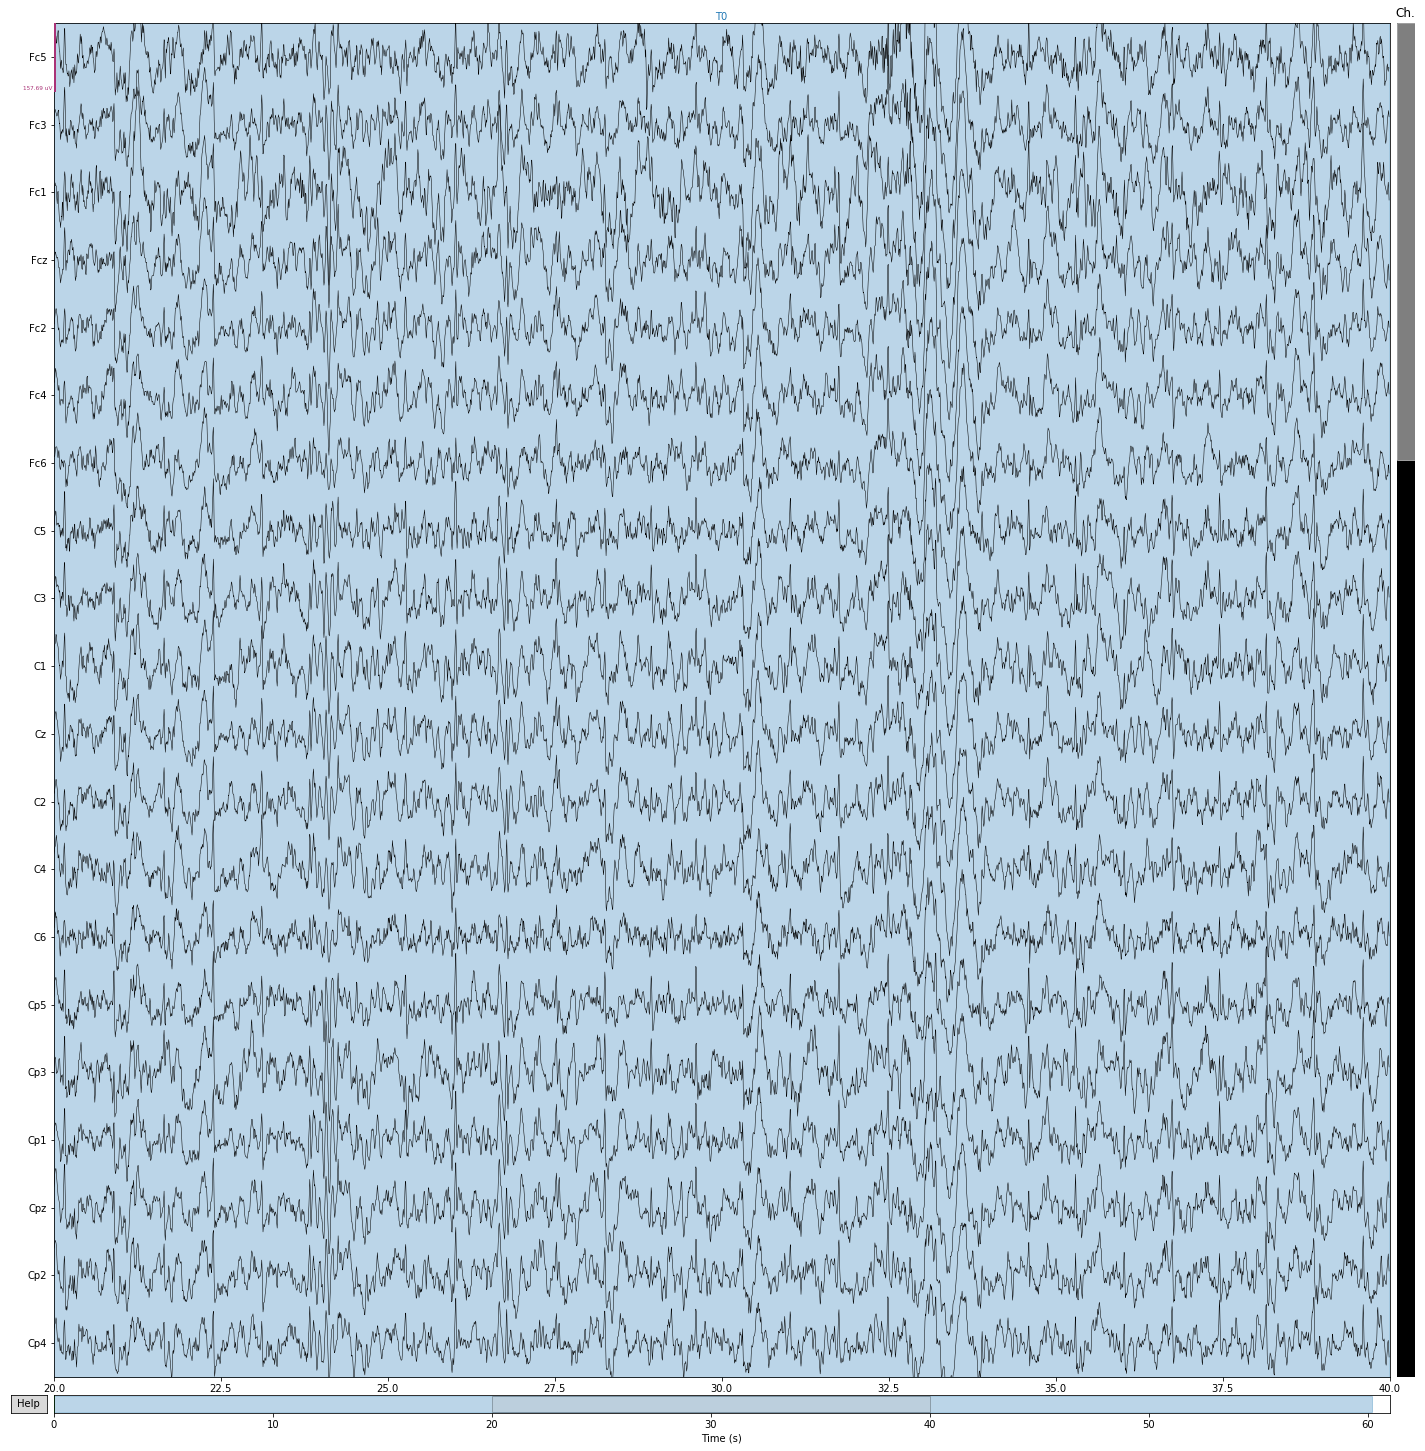

In [846]:
mne.viz.plot_raw(
    eeg_to_work, 
    start=start, 
    duration=stop - start, 
    show=False, 
    scalings=np.percentile(np.abs(filtered_eeg[0:10000][0]), 99)
)
plt.show()

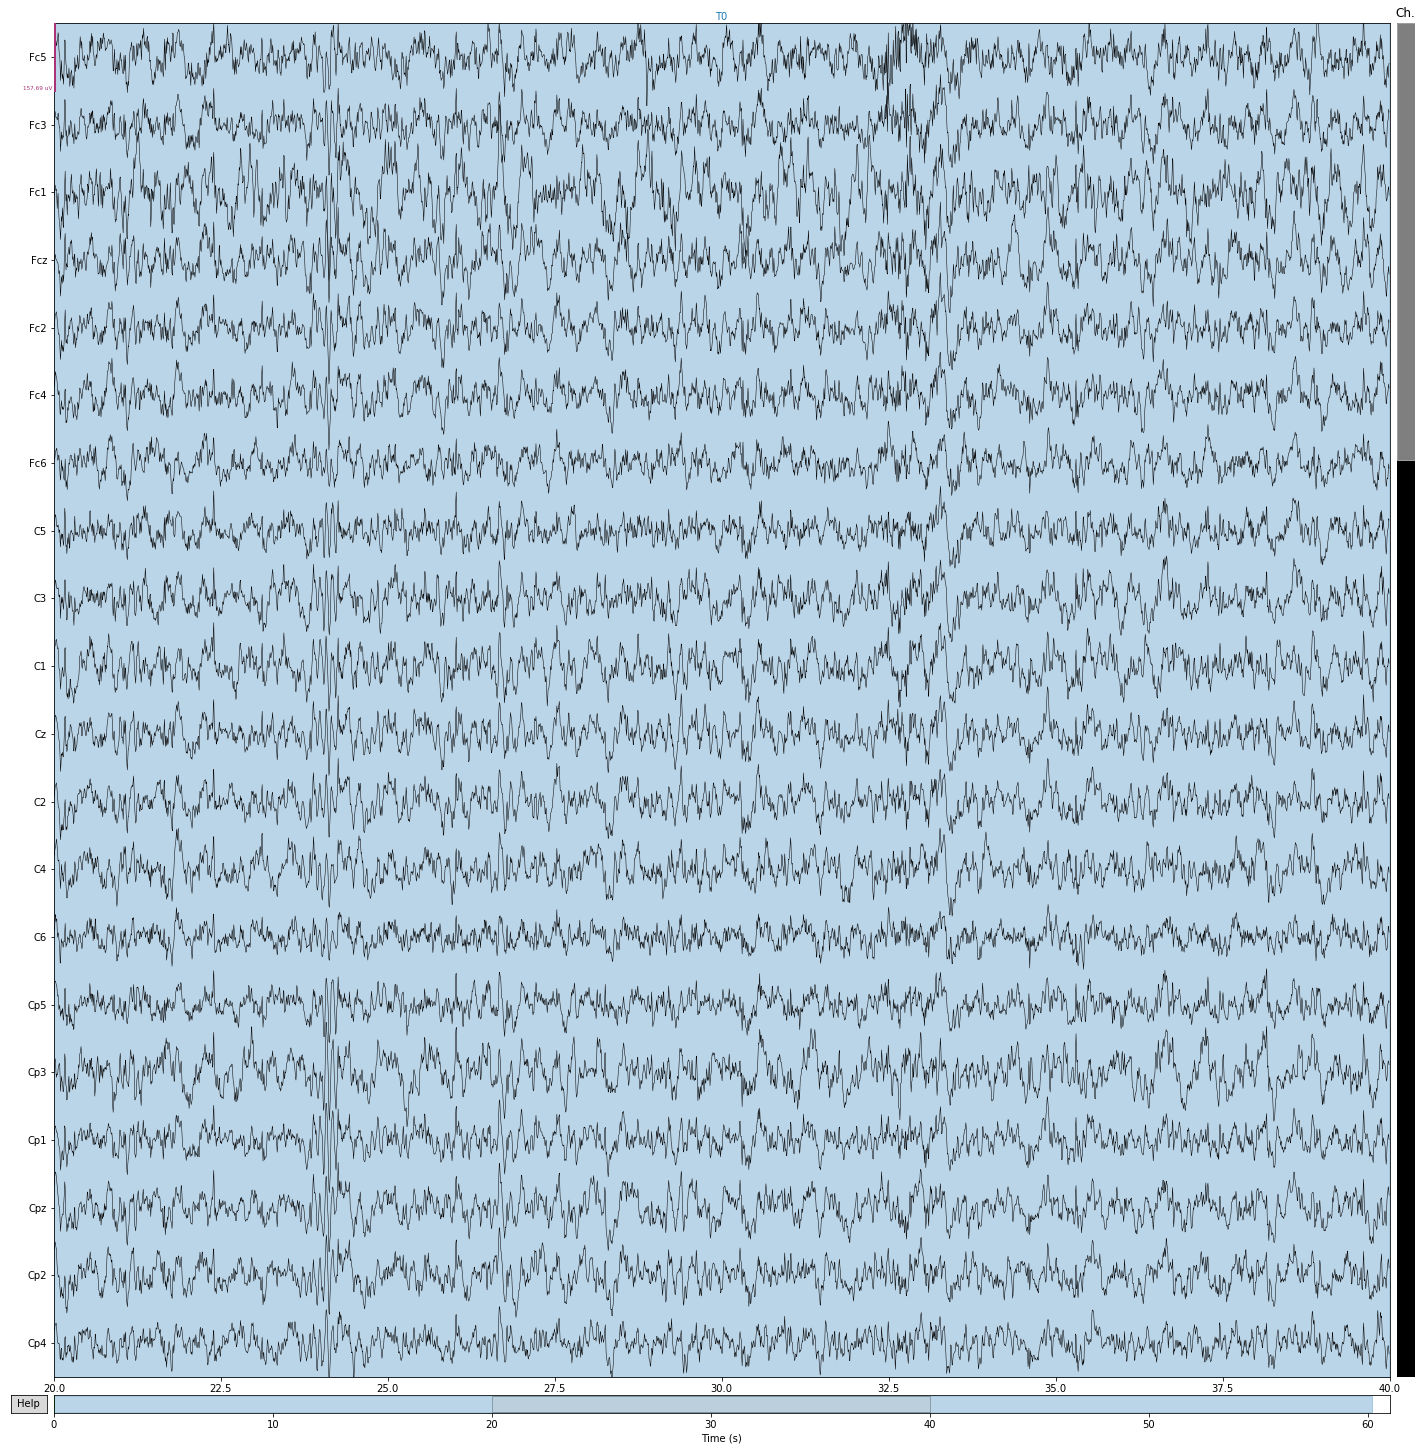

In [845]:
mne.viz.plot_raw(
    filtered_eeg, 
    start=start, 
    duration=stop - start, 
    show=False, 
    scalings=np.percentile(np.abs(filtered_eeg[0:10000][0]), 99)
)
plt.show()

http://mne.tools/mne-biomag-group-demo/auto_examples/demos/plot_ica.html